In [1]:
import pandas as pd
from scipy import stats
import pickle
#%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from matplotlib import rcParams
from statsmodels.stats.multitest import multipletests
from multiprocessing import Pool
import datetime
from scipy.stats import t as t_dist

In [2]:
def testSignificance(data, dof):
    t = data * np.sqrt((dof/((data+1.0)*(1.0-data))).clip(0))
    print("count t")
    prob = 2 * t_dist.sf(np.abs(t), dof)
    t = None
    print("count p-values")
    return multipletests(prob, alpha=0.05, method='fdr_bh')[0]#Boolean mask

In [3]:
def makeCorrespCorrs(target, anno_file_name, signal_file_name):
    
    anno = pd.read_csv("../all_marks/" + target + "/" + anno_file_name, sep="\t")
    anno['feature'] = [i.split('.')[0] for i in anno['feature']]
    chip = pd.read_csv("../all_marks/" + target + "/" + signal_file_name, sep="\t", index_col=0)
    rna = pd.read_csv("../all_marks/" + target + "/rna_matrix_norm.csv", sep="\t", index_col=0)
    rna.index = [i.split(".")[0] for i in rna.index]
    
    #откуда такая разница?(между encode списком и gencode аннотацией)
    common_genes = set(rna.index).intersection(set([i.split('.')[0] for i in anno['feature']]))
    rna = rna.loc[common_genes]
    anno = anno[anno['feature'].isin(common_genes)]
    
    print("Make matrices...")
    X = stats.mstats.rankdata(chip.loc[anno['peak']].values, axis=1)
    X = X.astype('float32')
   
    Y = stats.mstats.rankdata(rna.loc[anno['feature']].values, axis=1)
    Y = Y.astype('float32')
    
    print("Make corrs...")
    #Векторизованная корреляция
    Xm = np.reshape(np.mean(X,axis=1),(X.shape[0],1))
    Ym = np.reshape(np.mean(Y,axis=1),(Y.shape[0],1))
    r_num = np.sum((X-Xm)*(Y-Ym), axis=1)
    r_den = np.sqrt(np.sum((X-Xm)**2, axis=1))*np.sqrt(np.sum((Y-Ym)**2,axis=1))
    corr = r_num/r_den
    
    print("Make significance...")
    signif_mask = testSignificance(corr, chip.shape[1] - 2)
    corr[~signif_mask] = 0
    
    print("Return nonzero corrs...")
    return corr[corr.nonzero()]

In [4]:
corrs = makeCorrespCorrs("H3K27me3", "broad_2_peaks_fantom_anno.csv", "broad_2_peaks_signal_matrix_norm.csv")

Make matrices...
Make corrs...


/home/mazurovev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/mazurovev/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/mazurovev/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/mazurovev/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Make significance...
count t
count p-values
Return nonzero corrs...


/home/mazurovev/.local/lib/python3.6/site-packages/statsmodels/stats/multitest.py:320: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha


In [5]:
len(corrs)

8279

In [4]:
corrs = makeCorrespCorrs("H3K27ac", "peaks_anno.csv", "peaks_signal_matrix_norm.csv")

Make matrices...
Make corrs...


/home/mazurovev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/mazurovev/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/mazurovev/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/mazurovev/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Make significance...
count t
count p-values
Return nonzero corrs...


/home/mazurovev/.local/lib/python3.6/site-packages/statsmodels/stats/multitest.py:320: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha


In [5]:
len(corrs)

70491

In [6]:
rcParams['figure.figsize'] = 11.7,8.27
rcParams["patch.force_edgecolor"] = True
sb.set(color_codes=True)

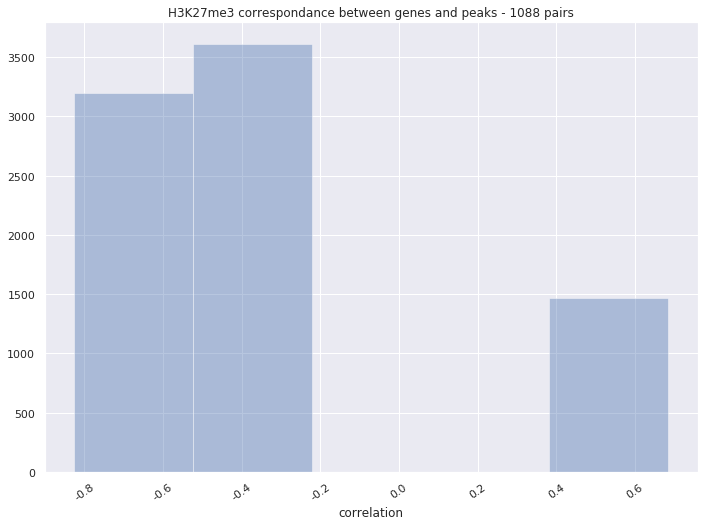

In [7]:
ax = sb.distplot(corrs, bins=5, kde=False)
ax.set_title("H3K27me3 correspondance between genes and peaks - 1088 pairs")
#ax.set_xticks([np.arange(-1, 1, 0.16)])
#ax.set_yticks(range(0, 70001, 10000))
ax.set_xticklabels(np.around(ax.get_xticks(), decimals=2), rotation=35)
ax.set(xlabel='correlation')
plt.show()

In [13]:
fig = ax.get_figure()
fig.patch.set_alpha(0)
fig.savefig("../all_marks/H3K27ac/plots/MakeCorrespondenceBetweenGenesAndPeaks_correlation_hist.png", bbox_inches='tight', pad_inches = 0)